In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Research Project Mango/Suresh - Mango Fruit Diseases'

/content/drive/MyDrive/Research Project Mango/Suresh - Mango Fruit Diseases


In [4]:
IMAGE_SHAPE = (224, 224)

In [5]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
training_data='/content/drive/MyDrive/Research Project Mango/Suresh - Mango Fruit Diseases'
training_image_data  = image_generator.flow_from_directory(training_data,target_size=IMAGE_SHAPE)

Found 731 images belonging to 4 classes.


In [6]:
training_image_data[1][1].shape

(32, 4)

In [7]:
validation_data='/content/drive/MyDrive/Research Project Mango/Suresh - Mango Fruit Diseases'
validation_image_data  = image_generator.flow_from_directory(validation_data,target_size=IMAGE_SHAPE)

Found 731 images belonging to 4 classes.


In [8]:
class_names = sorted(training_image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Alternaria', 'Anthracnose', 'Black Mould Rot', 'Stem And Rot'],
      dtype='<U15')

In [9]:
base_model=tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = models.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,573,828 (13.63 MB)

 Trainable params: 1,315,844 (5.02 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
for image_batch, label_batch in training_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 4)


In [12]:
model.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['acc'])

In [13]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

In [14]:
history = model.fit(training_image_data, epochs = 10,validation_data=validation_image_data, callbacks=[batch_stats_callback])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 166s 6s/step - acc: 0.5994 - loss: 1.0247 - val_acc: 0.7921 - val_loss: 0.5027
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - acc: 0.7909 - loss: 0.4422 - val_acc: 0.9042 - val_loss: 0.3119
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - acc: 0.8417 - loss: 0.3265 - val_acc: 0.9371 - val_loss: 0.2208
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - acc: 0.8862 - loss: 0.2229 - val_acc: 0.8851 - val_loss: 0.2724
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - acc: 0.9036 - loss: 0.1779 - val_acc: 0.9767 - val_loss: 0.1183
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - acc: 0.9164 - loss: 0.1389 - val_acc: 0.9850 - val_loss: 0.0871
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - acc: 0.9401 - loss: 0.0979 - val_acc: 0.9836 - val_loss: 0.0814
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step - acc: 0.9381 - loss: 0.0842 - val_acc: 0.9891 - val_loss: 0.0789
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - acc: 0.9425 - loss: 0.

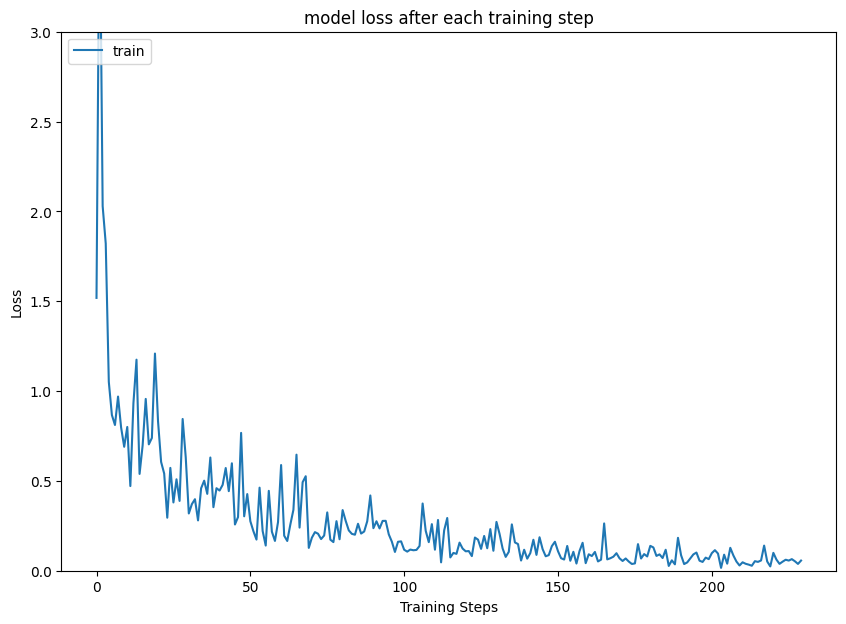

In [15]:
plt.figure(figsize=(10,7))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,3])
plt.plot(batch_stats_callback.batch_losses)
plt.title('model loss after each training step')
plt.legend(['train'], loc='upper left')

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


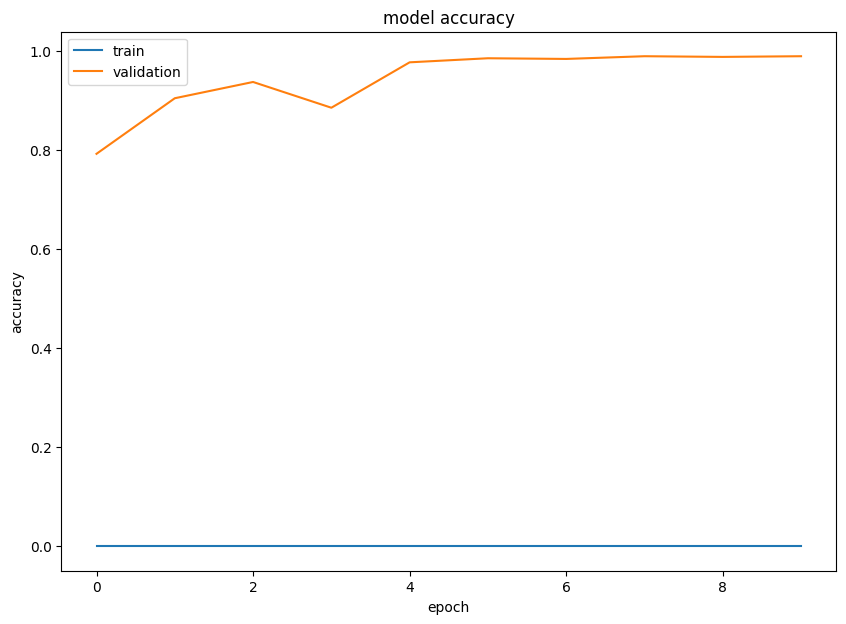

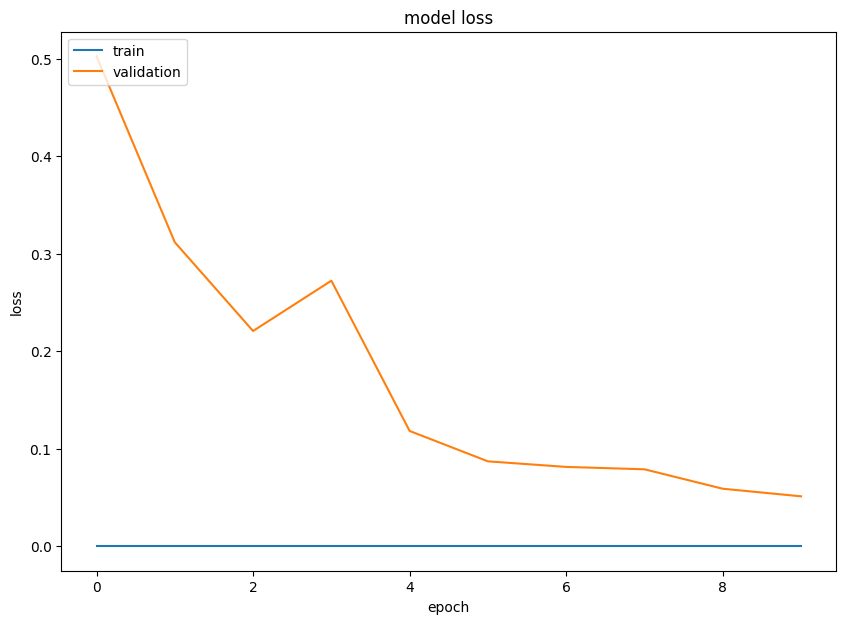

In [16]:
print(history.history.keys())

plt.figure(figsize=(10,7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
from tensorflow.keras.models import load_model

model.save('sample_model.h5')


In [18]:
arr = model.predict(image_batch)
predicted_id = np.argmax(arr, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)
true_label_batch = class_names[label_id]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


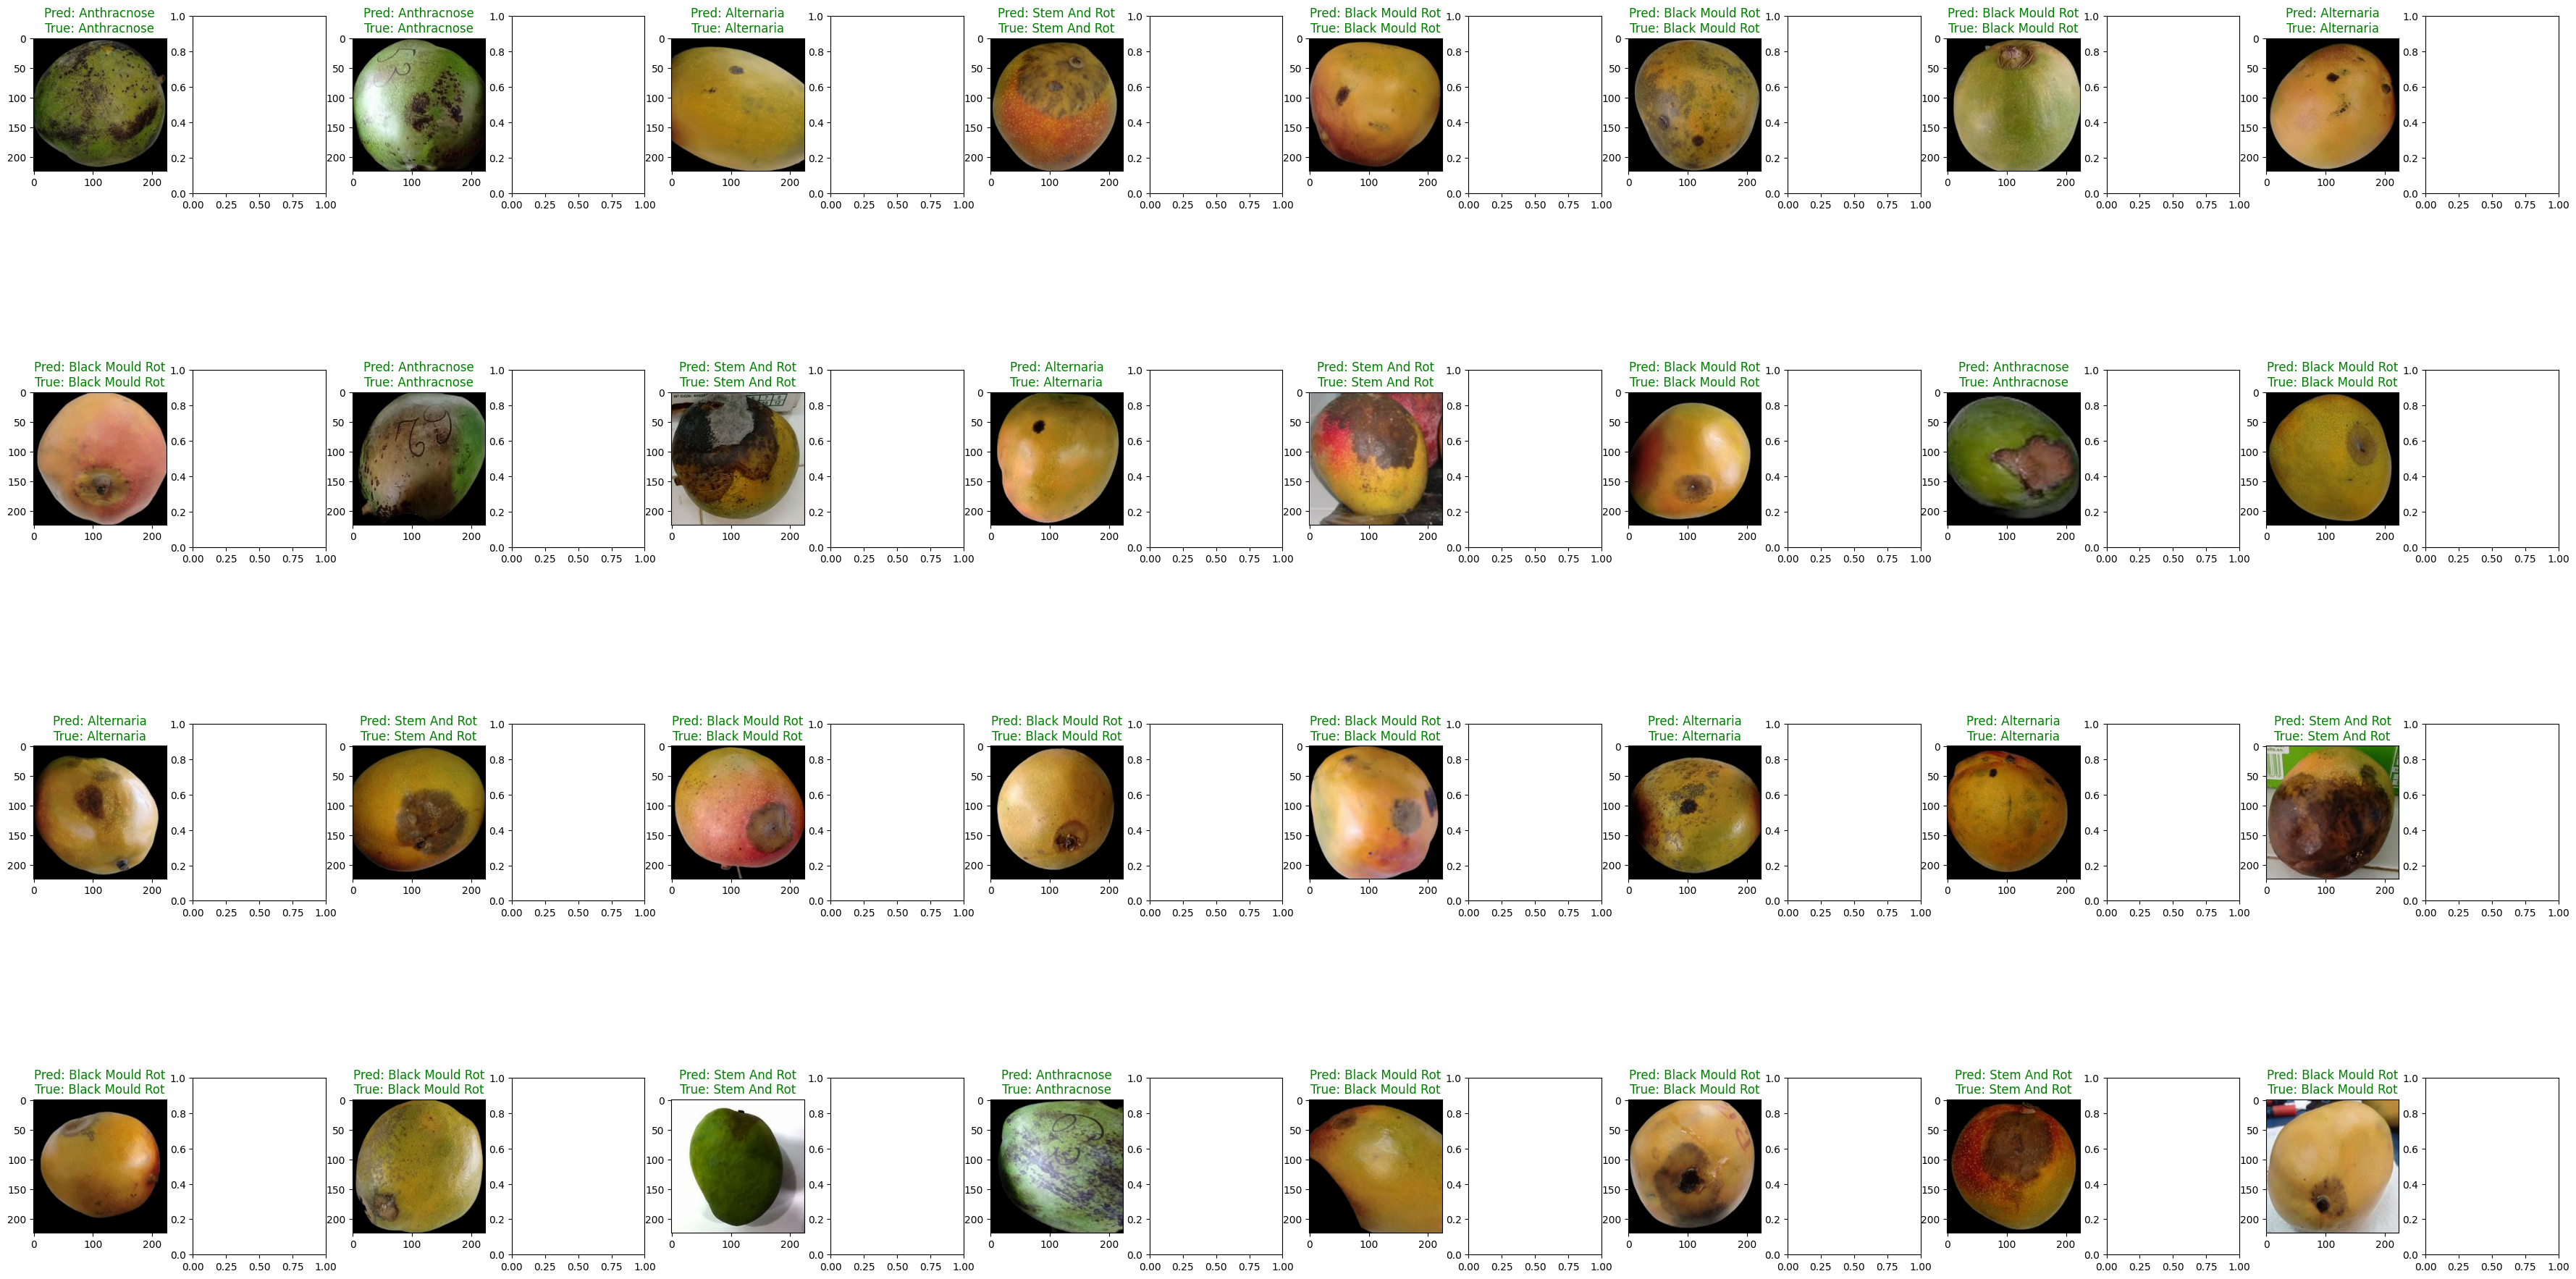

In [19]:
img_counter=0
prob_counter=0

plt.figure(figsize=(45,200))
plt.subplots_adjust(hspace=1)
for n in range(64):

  plt.subplot(32,16,n+1)
  if(n%2==0):
      plt.imshow(image_batch[img_counter])
      color = "green" if predicted_id[img_counter] == label_id[img_counter] else "red"
      plt.title("Pred: "+predicted_label_batch[img_counter].title()+"\nTrue: "+true_label_batch[img_counter], color=color)
      img_counter=img_counter+1


In [20]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_batch, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


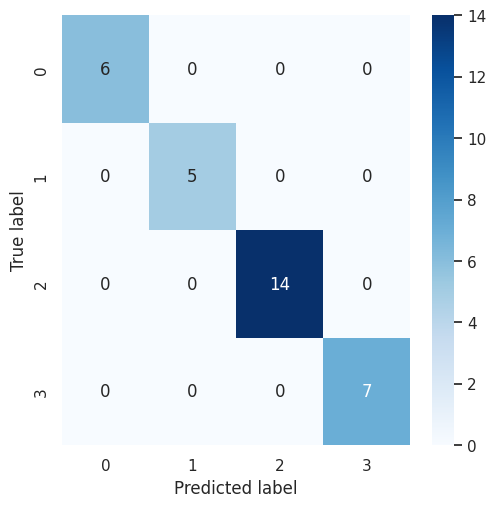

In [21]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

con_mat_df=tf.math.confusion_matrix(
    labels = label_id , predictions = predicted_id
)

figure = plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
from sklearn.metrics import classification_report
print(classification_report(label_id, predicted_id, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [23]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [24]:
model= tf.keras.models.load_model(
       ('sample_model.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [25]:
img=image.load_img('/content/drive/MyDrive/Research Project Mango/Suresh - Mango Fruit Diseases/Alternaria/Alternaria_017.jpg',target_size=IMAGE_SHAPE)

In [26]:
x=image.img_to_array(img)
x.shape

(224, 224, 3)

In [27]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [28]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [29]:
model.predict(img_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.96205163, 0.0055883 , 0.02801307, 0.00434706]], dtype=float32)

In [30]:
np.argmax(model.predict(img_data), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


array([0])

In [31]:
classes=class_names

In [32]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)
    prob = prediction

    index = np.argmax(prediction)
    confidence = prob[0][index]


    if confidence >= 0.5:
        plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='brown')
        plt.imshow(img_array)
    else:
        plt.title("Not Detected", size=18, color='yellow')
        plt.imshow(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


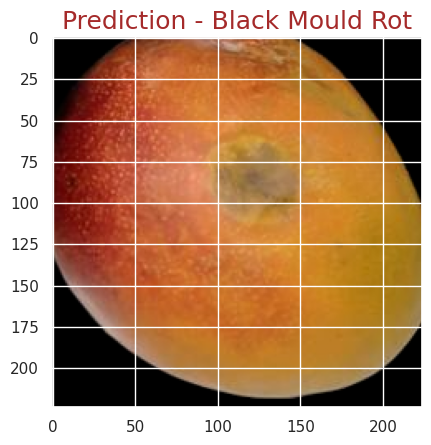

In [33]:
predict_image('/content/drive/MyDrive/Research Project Mango/Suresh - Mango Fruit Diseases/Black Mould Rot/Aspergillus_006.jpg', model)

Saving Alternaria_010.jpg to Alternaria_010.jpg
File uploaded: Alternaria_010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


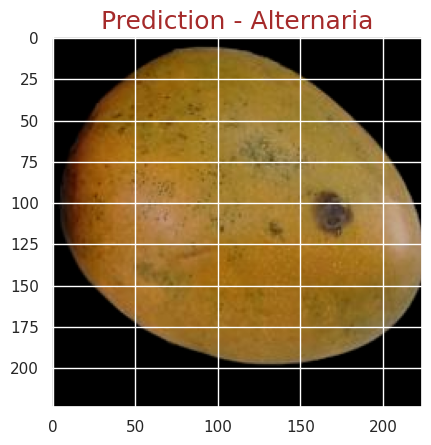

In [34]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'File uploaded: {filename}')
    predict_image(filename, model)